# Required Dependencies

In [1]:
!pip install pytorch-ignite

     |████████████████████████████████| 232 kB 10.5 MB/s 


In [2]:
import torch
torch.__version__

'1.9.0+cu102'

In [3]:
import torchvision
torchvision.__version__

'0.10.0+cu102'

In [4]:
import ignite
ignite.__version__

'0.4.6'

# Import Libraries

In [5]:
import logging
import matplotlib.pyplot as plt

from PIL import Image

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam

from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

from ignite.engine import Engine, Events
import ignite.distributed as idist

## Reproductibility and logging details


In [6]:
ignite.utils.manual_seed(999)

The `logging` level `logging.WARNING` is used in internal `ignite` submodules in order to avoid internal messages.

In [7]:
ignite.utils.setup_logger(name="ignite.distributed.auto.auto_dataloader", level=logging.WARNING)
ignite.utils.setup_logger(name="ignite.distributed.launcher.Parallel", level=logging.WARNING)

<Logger ignite.distributed.launcher.Parallel (WARNING)>

In [8]:
device = idist.device()

# Processing Data
For this notebook, we will be using the 2014 training data from [COCO dataset](https://cocodataset.org/#download). This dataset has more than 80000 images spanning over 91 classes. It provides us a wide variety of images to work with for training our model. Here we download and use [ImageFolder](https://pytorch.org/vision/stable/datasets.html) class provided by `torchvision` library to define our own dataset.

In [9]:
!wget http://images.cocodataset.org/zips/train2014.zip

--2021-08-14 08:01:15--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.204.137
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.204.137|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  43.4MB/s    in 5m 11s  

2021-08-14 08:06:26 (41.5 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]



In [10]:
!unzip -qq train2014.zip -d data

In [11]:
!wget https://raw.githubusercontent.com/pytorch/examples/master/fast_neural_style/images/style-images/mosaic.jpg

--2021-08-14 08:12:52--  https://raw.githubusercontent.com/pytorch/examples/master/fast_neural_style/images/style-images/mosaic.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77378 (76K) [image/jpeg]
Saving to: ‘mosaic.jpg’

mosaic.jpg          100%[===================>]  75.56K  --.-KB/s    in 0.008s  

2021-08-14 08:12:53 (9.79 MB/s) - ‘mosaic.jpg’ saved [77378/77378]



In [12]:
!mkdir checkpoints

## Dataset and transformation

We define important model and training parameters such as `batch_size`, `image_size`, `learning_rate` etc here.

In [13]:
dataset = './data/'
batch_size = 4
image_size = 256
lr = 1e-3
style_image = "mosaic.jpg"
style_size = 256
content_weight = 1e5
style_weight = 1e10
log_interval = 500
checkpoint_interval = 2000
checkpoint_model_dir = './checkpoints/'

In [14]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])
train_dataset = datasets.ImageFolder(dataset, transform)

## DataLoading

We wish to configure the dataloader to work in a disbtributed environment. Distributed Dataloading is support by Ignite as part of DDP support. This requires specific adjustments to the sequential case.

To handle this, `idist` provides an helper [`auto_dataloader`](https://pytorch.org/ignite/v0.4.5/generated/ignite.distributed.auto.auto_dataloader.html#auto-dataloader) which automatically distributes the data over the processes.

**Note**: Distributed dataloading is described in [Distributed Data Parallel (DDP)](https://pytorch.org/tutorials/intermediate/ddp_tutorial.html) tutorial if you wish to learn more.

In [15]:
train_loader = idist.auto_dataloader(
    train_dataset, 
    batch_size=batch_size, 
    num_workers=2, 
    shuffle=True, 
    drop_last=True,
)   

Let's explore the data.

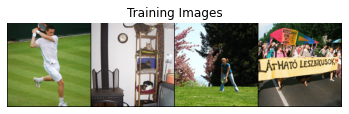

In [16]:
real_batch = next(iter(train_loader))

plt.figure()
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:4], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [17]:
class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

# Model for Fast Neural Style Transfer

In [18]:
class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out

In [19]:
class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [20]:
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y

As for dataloading, distributed models requires some specifics that `idist` adresses providing the [`auto_model`](https://pytorch.org/ignite/v0.4.5/generated/ignite.distributed.auto.auto_model.html#auto-model) helper.

In [21]:
transformer = idist.auto_model(TransformerNet()).to(device)

## PPL Loss

### Style Loss

In [22]:
from collections import namedtuple
from torchvision import models


class Vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

In [23]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram


def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div_(255.0)
    return (batch - mean) / std

In [24]:
optimizer = idist.auto_optim(Adam(transformer.parameters(), lr))

### Content Loss

In [25]:
mse_loss = torch.nn.MSELoss()

### Utility Functions
Here we have defined two utility functions `load_image` and `save_image` which are responsible for loading and saving images as their name suggests.

In [26]:
from PIL import Image


def load_image(filename, size=None, scale=None):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    return img


def save_image(filename, data):
    img = data.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = Image.fromarray(img)
    img.save(filename)

In [27]:
vgg = Vgg16(requires_grad=False).to(device)
style_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])
style = load_image(style_image, size=style_size)
style = style_transform(style)
style = style.repeat(batch_size, 1, 1, 1).to(device)

features_style = vgg(normalize_batch(style))
gram_style = [gram_matrix(y) for y in features_style]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [28]:
agg_content_loss = 0.
agg_style_loss = 0.
count = 0
batch_id = 0

In [29]:
import time
import os

# Ignite Training Concepts

Training in Ignite is based on three core components, namely, Engine, Events and Handlers. Let's briefly discuss each of them.

*   **Engine** - The [Engine](https://pytorch.org/ignite/v0.4.5/generated/ignite.engine.engine.Engine.html#engine) can be considered somewhat similar to a training loop. It takes a `train_step` as an argument and runs it  over each batch of the dataset, emmiting events as it goes.

*   **Events** - [Events](https://pytorch.org/ignite/v0.4.5/generated/ignite.engine.events.Events.html#events) are emmited by the Engine when it reaches a specific point in the run/training.

*   **Handlers** - These are [functions](https://pytorch.org/ignite/v0.4.5/handlers.html#ignite-handlers) which can be configured so that they are triggered when a certain Event is emmited by the Engine. Ignite has a long list of pre defined Handlers such as checkpoint, early stopping, logging and built-in metrics.

In [30]:
def training_step(engine, data):
    global count, agg_content_loss, agg_style_loss, batch_id
    x = data[0]
    transformer.train()
    n_batch = len(x)
    count += n_batch
    optimizer.zero_grad()

    x = x.to(device)
    y = transformer(x)

    y = normalize_batch(y)
    x = normalize_batch(x)

    features_y = vgg(y)
    features_x = vgg(x)

    content_loss = content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)

    style_loss = 0.
    for ft_y, gm_s in zip(features_y, gram_style):
        gm_y = gram_matrix(ft_y)
        style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
    style_loss *= style_weight

    total_loss = content_loss + style_loss
    total_loss.backward()
    optimizer.step()

    agg_content_loss += content_loss.item()
    agg_style_loss += style_loss.item()

    if (batch_id + 1) % log_interval == 0:
        mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
            time.ctime(), 1, count, len(train_dataset),
                            agg_content_loss / (batch_id + 1),
                            agg_style_loss / (batch_id + 1),
                            (agg_content_loss + agg_style_loss) / (batch_id + 1)
        )
        print(mesg)

    if checkpoint_model_dir is not None and (batch_id + 1) % checkpoint_interval == 0:
        transformer.eval().cpu()
        ckpt_model_filename = "ckpt_epoch_" + str(1) + "_batch_id_" + str(batch_id + 1) + ".pth"
        ckpt_model_path = os.path.join(checkpoint_model_dir, ckpt_model_filename)
        torch.save(transformer.state_dict(), ckpt_model_path)
        transformer.to(device).train()
    
    batch_id += 1

In [31]:
trainer = Engine(training_step)

In [32]:
from ignite.contrib.handlers import ProgressBar

ProgressBar().attach(trainer)

In [33]:
def training(*args):
    trainer.run(train_loader, max_epochs=2)

In [34]:
with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)

[1/20695]   0%|           [00:00<?]

Sat Aug 14 08:15:15 2021	Epoch 1:	[2000/82783]	content: 1917985.634313	style: 9707167.986000	total: 11625153.620313
Sat Aug 14 08:17:24 2021	Epoch 1:	[4000/82783]	content: 2088529.677031	style: 5655229.696250	total: 7743759.373281
Sat Aug 14 08:19:32 2021	Epoch 1:	[6000/82783]	content: 2152837.238937	style: 4092106.943542	total: 6244944.182479
Sat Aug 14 08:21:40 2021	Epoch 1:	[8000/82783]	content: 2178611.351203	style: 3255240.138125	total: 5433851.489328
Sat Aug 14 08:23:48 2021	Epoch 1:	[10000/82783]	content: 2185148.386162	style: 2735506.342050	total: 4920654.728212
Sat Aug 14 08:25:56 2021	Epoch 1:	[12000/82783]	content: 2179738.387802	style: 2379854.697406	total: 4559593.085208
Sat Aug 14 08:28:04 2021	Epoch 1:	[14000/82783]	content: 2168099.993723	style: 2122774.105152	total: 4290874.098875
Sat Aug 14 08:30:12 2021	Epoch 1:	[16000/82783]	content: 2153887.046258	style: 1927257.712062	total: 4081144.758320
Sat Aug 14 08:32:20 2021	Epoch 1:	[18000/82783]	content: 2136680.502757	sty

[1/20695]   0%|           [00:00<?]

Sat Aug 14 09:42:43 2021	Epoch 1:	[84000/82783]	content: 1813253.626912	style: 729978.021497	total: 2543231.648409
Sat Aug 14 09:44:51 2021	Epoch 1:	[86000/82783]	content: 1808715.815042	style: 722373.377951	total: 2531089.192993
Sat Aug 14 09:46:58 2021	Epoch 1:	[88000/82783]	content: 1804331.849155	style: 714960.271010	total: 2519292.120165
Sat Aug 14 09:49:06 2021	Epoch 1:	[90000/82783]	content: 1799945.887624	style: 707964.428126	total: 2507910.315750
Sat Aug 14 09:51:14 2021	Epoch 1:	[92000/82783]	content: 1795858.044697	style: 701147.996340	total: 2497006.041037
Sat Aug 14 09:53:22 2021	Epoch 1:	[94000/82783]	content: 1791837.025852	style: 694666.914351	total: 2486503.940203
Sat Aug 14 09:55:30 2021	Epoch 1:	[96000/82783]	content: 1788016.115845	style: 688419.154066	total: 2476435.269911
Sat Aug 14 09:57:38 2021	Epoch 1:	[98000/82783]	content: 1784272.889501	style: 682369.093357	total: 2466641.982858
Sat Aug 14 09:59:46 2021	Epoch 1:	[100000/82783]	content: 1780881.758416	style: 